# Tkinter y PyInstaller para archivos Python ejecutables
*Tkinter* es una librería de *python* que nos permite crear interfaces gráficas para nuestros programas. *PyInstaller* es una librería que nos permite compilar código de python y sus dependencias en un solo archivo ejecutable. Combinadas ambas librerías son herramientas útiles que podrían servir en el ámbito laboral para compartir programas con otros equipos sin la necesidad de que estos tengan algún lenguaje de programación instalado. En esta notebook vamos a crea una interfaz gráfica simple para un programa que procese archivos de excel usando *Tkinter* y compilarla para crear un archivo ejecutable con *Pyinstaller*.

En este caso vamos a usar el siguiente [dataset de Kaggle](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting?resource=download) que contiene información de ventas de un negocio durante 4 años. Vamos a realizar algunas tareas de procesamiento y luego exportar el output en una nueva tabla de excel a través de la interfaz gráfica creada con *Tkinter*.

1. Vamos a escribir el código en **Jupyter Notebook** del procesamiento que queremos hacerle a nuestros datos.
2. Vamos a reescribir el código para adaptarlo a **Tkinter** y crear una interfaz gráfica para el mismo.
3. Vamos a compilar el código usando **PyInstaller** y crear un archivo ejecutable para poder acceder al programa sin necesidad de tener python instalado.

In [90]:
# Importamos las librerías necesarias
import tkinter as tk
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Código para Jupyter Notebook

In [44]:
# Cargamos la información
files = [x for x in os.listdir() if x.endswith('.csv')]
data = pd.read_csv(files[0])

In [47]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


El dataset tiene mucha información y podríamos realizar muchos análisis distintos, pero en este caso nos vamos a concentrar en obtener la evolución de las ventas semanales para el último año y un gráfico para la distribución de ventas por categoría para el último mes. Vamos a quedarnos entonces con la información de fecha, ventas y categoría.

In [48]:
data = data[['Order ID','Order Date','Category','Sales']]
data.columns = ['_'.join(x.split()).lower() for x in data.columns]
data.order_date = pd.to_datetime(data.order_date, format = '%d/%m/%Y')
data.category = data.category.astype('category')

In [118]:
weekly_data = data[['order_date','sales']]
weekly_data['year'] = pd.DatetimeIndex(weekly_data['order_date']).year
years = list(weekly_data.year.unique())
weekly_data = weekly_data.loc[weekly_data.year == max(years),:]
weekly_data.set_index('order_date',inplace = True)
del weekly_data['year']
weekly_data.sort_index(inplace=True)
weekly_data = weekly_data.resample('W').sum()
weekly_data.reset_index(inplace = True)
weekly_data.columns = ['week','sales']
weekly_data.head()

<ipython-input-118-974f02c626f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data['year'] = pd.DatetimeIndex(weekly_data['order_date']).year


,week,sales
0,2018-01-07,9060.984
1,2018-01-14,7332.659
2,2018-01-21,13698.768
3,2018-01-28,9476.086
4,2018-02-04,5776.328


In [119]:
chart_data = data[['order_date','sales','category']]
chart_data['year'] = pd.DatetimeIndex(chart_data['order_date']).year
chart_data['month'] = pd.DatetimeIndex(chart_data['order_date']).month
chart_data = chart_data.loc[(chart_data.year == max(chart_data.year)) & (chart_data.month == max(chart_data.month))]

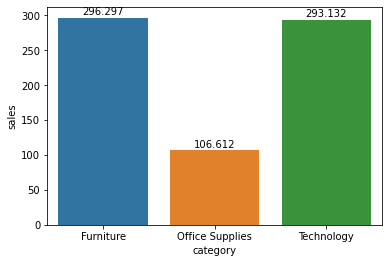

In [116]:
ax = sns.barplot(x="category", y="sales", data=chart_data, ci = 0)
ax.bar_label(ax.containers[0],padding = 1)
plt.show()

Ya tenemos el output que queríamos, lo que vamos a hacer ahora es reescribir el código para adaptarlo a *Tkinter* y luego compilarlo con *Pyinstaller*.

## Código para Tkinter

In [114]:
# Definimos una función que contenga el procesamiento que hicimos en el paso anterior
def process_info(file, path, path_export):

    # Importamos la información
    data = pd.read_csv(path + file)
    
    data = data[['Order ID','Order Date','Category','Sales']]
    data.columns = ['_'.join(x.split()).lower() for x in data.columns]
    data.order_date = pd.to_datetime(data.order_date, format = '%d/%m/%Y')
    data.category = data.category.astype('category')
    data['year'] = pd.DatetimeIndex(data['order_date']).year
    data['month'] = pd.DatetimeIndex(data['order_date']).month
    
    # Información para el csv con las ventas semanales del último año
    weekly_data = data[['order_date','sales','year']]
    weekly_data = weekly_data.loc[weekly_data.year == max(weekly_data.year)]
    weekly_data.set_index('order_date',inplace = True)
    weekly_data.sort_index(inplace=True)
    weekly_data = weekly_data.resample('W').sum()
    weekly_data.reset_index(inplace = True)
    weekly_data.columns = ['week','sales']
    weekly_data.to_csv(path_export + 'weekly_sales.csv',index = False)
    
    # Información para exportar imagen con ventas por categoría último mes
    chart_data = data[['order_date','sales','category','year','month']]
    chart_data = chart_data.loc[(chart_data.year == max(chart_data.year)) & (chart_data.month == max(chart_data.month))]
    ax = sns.barplot(x="category", y="sales", data=chart_data, ci = 0)
    ax.bar_label(ax.containers[0],padding = 1)
    plt.savefig(path_export + 'sales_per_category_last_week.png')

En la siguiente celda construimos la interfaz gráfica con Tkinter, y al ejecutarla se abrirá una ventana en la que completamos path y path de exportación, con un botón que da inicio al procesamiento y la exportación de los resultados.
El path debe estar escrito en el siguiente formato: **/path/hacia/la/carpeta/de/ubicación/de/los/archivos/**

In [120]:
root=tk.Tk()
root.title("Sales Data")
root.geometry("250x100")

path_var = tk.StringVar() ## path hacia el archivo de datos
pathe_var = tk.StringVar()## path para la exportación de los resultados
  
# Declaramos la función que toma como inputs el path donde están los files y el path en el cual queremos
# exportar el resultado
def submit(): 
    ## tomamos el path escrito arriba
    path = path_var.get() 
    path_export = pathe_var.get()
    ## obtenemos los archivos .csv del path declarado
    files = [x for x in os.listdir(path) if x.endswith('.csv')]
    process_info(files[0], path, path_export)
    
# Diseñamos el aspecto de la interfaz gráfica
path_label = tk.Label(root, text = 'Path', font = ('calibre',10,'bold'))
# Este será el espacio para escribir el path en la interfaz gráfica
path_entry=tk.Entry(root, textvariable = path_var, font = ('calibre',10,'normal')) 

pathe_label = tk.Label(root, text = 'Export', font = ('calibre',10,'bold'))
# Este será el espacio para escribir el path de exportación en la interfaz gráfica
pathe_entry=tk.Entry(root, textvariable = pathe_var, font = ('calibre',10,'normal'))

sub_btn=tk.Button(root,text = 'Submit', command = submit) # Declaramos el botón que de inicio al procesamiento
  
path_label.grid(row=1,column=0)
path_entry.grid(row=1,column=1)
pathe_label.grid(row=2,column=0)
pathe_entry.grid(row=2,column=1)
sub_btn.grid(row=3,column=1)

root.mainloop()

## Código para Pyinstaller

Para continuar vamos a crear un archivo python que contenga el mismo código que el que escribimos en la sección "Código para Tkinter" (**además de las líneas para importar las librerías necesarias**) . Una vez creado el archivo abrimos la consola de comandos, navegamos hacia la dirección del arhivo .py creado y ejecutamos la siguiente línea:
```python
pyinstaller nombre_del_archivo.py --onefile --windowed
```
El resultado es el siguiente:
- Un archivo nombrearchivo.spec en la carpeta del archivo.
- Una carpeta build en la misma carpeta del archivo.
- Algunos log files en la carpeta build.
- **Una carpeta dist que contiene al archivo ejecutable con el programa con la interfaz gráfica de Tkinter en su interior que permite ejecutar el procesamiento de los datos.**

Estos archivos generados pueden compartirse con personas que no tengan python instalado e igual podrán ejecutar el programa.